# 構成
|-- *activation_funcs.py ：アクティベート関数(sigmoid関数 / softmax関数)*<br>
|-- *error_funcs.py ： エラー関数(二乗誤差関数 / 交差エントロピー関数)*<br>
|-- *fonc.py：呼び出し名を用意させる*<br>
|-- *layers.py ：１層、２層の層部分を構成*<br>
|-- *networks.py：全体を構成*<br>

# Func
ネットワーク構成において名前で呼び出せるように親クラスを用意しておく

In [1]:
class Function:
    name = ' '
    
    def get_value(self, *args, **kwargs):
        raise NotImplementedError
        
    def get_derivative(self, *args, **kwargs):
        raise NotImplementedError

# Error_funcs
エラー関数を用意<br>
*二乗誤差関数　と　交差エントロピー関数がある*
- get_value()：Fowardの通常出力
- get_derivative()：関数の微分に入力値を与えて微分値を取得

In [2]:
import numpy as np
# from nn.func import Function

class SquaredError(Function):
    """二乗誤差関数"""
    name = "se"
    
    def get_value(self, t, y):
        """通常出力"""
#         print("t=%s,      y=%s" % (t,y))
        return ((t - y).T @ (t - y)).ravel()[0] / 2.0  # flatten()よりravel()がいい
   
    def get_derivative(self, t, y):
        return -(t - y)
    
    
class CrossEntropy(Function):
    """交差エントロピー関数"""
    name = "cross_entropy"
    
    def get_value(self, t, y):
        return -(t.T @np.log(y)).ravel()[0]
    
    def get_derivative(self, t, y):
        return - t/y

# Activation_funcs
アクティベート関数<br>
*シグモイド関数　と　softmax関数が今回使用される*
- get_value()：Fowardの通常出力
- get_derivative()：関数の微分に入力値を与えて微分値を取得

assert ：条件式, 条件式がFalseの場合に出力するメッセージ

条件式が False の場合、AssertionError の例外が発生します。<br>
条件式が True の場合は何も起こりません。


In [3]:
import numpy as np
from copy import deepcopy
# from nn.func import Function


class Logistic(Function):
    """シグモイド関数"""
    name = 'logistic'
    
    def get_value(self, s):
        return 1 / (1 + np.exp(-s))
    
    def get_derivative(self, y):
        assert isinstance(y, np.ndarray) and y.shape[1] == 1
        jacobian = np.zeros(shape=(y.shape[0], y.shape[0]))
        jacobian[np.diag_indices(y.shape[0])] = (y * (1 - y)).ravel()
        return jacobian
    

class Tanh(Function):
    name = 'tanh'
    
    def __init__(self, alpha, beta):
        self._alpha = alpha
        self._beta = beta
        
    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    def get_value(self, s):
        return self._alpha * np.tanh(self._beta * s)
    
    def get_derivative(self, y):
        assert isinstance(y, np.ndarray) and y.shape[1] == 1
        derivative = np.zeros(shape=(y.shape[0], y.shape[0]))
        derivative[np.diag_indices(y.shape[0])] = self._alpha * self._beta * \
        (1 - np.power(np.tanh(self._beta * y.flatten()), 2))
        return derivative
    
    
class Softmax(Function):
    """softmax関数"""
    name = 'softmax'
    
    def get_value(self, s):
        _s = s - np.max(s)
        exp_s = np.exp(_s)
        value = exp_s / np.sum(exp_s)
        value[value < 10e-7] = 10e-7   # 小さすぎる場合10e-7で切ってる
        value[value > 10e+7] = 10e+7 # 大きすぎる場合10e-7で切ってる
        return value / np.sum(value)
    
    def get_derivative(self, y):
        assert isinstance(y, np.ndarray) and y.shape[1] == 1
        y_diag = np.zeros(shape=(y.shape[0], y.shape[0]))
        np.fill_diagonal(y_diag, y.flatten())
        return y_diag - y @ y.T
    
    
class Rectifier(Function):
    def get_value(self, s):
        val = deepcopy(s)
        val[val < 0.0] = 0.0
        return val

    def get_derivative(self, y):
        val = deepcopy(y)
        val[val > 0.0] = 1.0
        val[val <= 0.0] = 0.0
        y_diag = np.zeros(shape=(y.shape[0], y.shape[0]))
        np.fill_diagonal(y_diag, val.flatten())
        return y_diag   

# Layers
１層、２層など各層をレイヤーとして層の中身を表記

In [4]:
import numpy as np
# from nn.activation_funcs import Logistic, Tanh, Softmax, Rectifier


class BaseLayer:
    name = 'base'

    def __init__(self, n_output, n_prev_output, f):
        """
        :param n_output: Number of this layer's output
        :param n_prev_output: Number of previous layer's output
        :param f: Activation function (callable)
        :param df: Derivative of the activation function (callable)
        """
        self._W = self._init_W(n_output, n_prev_output)
        self._b = self._init_b(n_output)
        self._f = f
        self._y = None
        self._delta = None

    def __str__(self):
        return self.name

    def _init_W(self, n_output, n_prev_output, **kwargs):
        """
        Way of initializing weight matrix W
        :param n_output: Number of this layer's output
        :param n_prev_output: Number of previous layer's output
        :param kwargs:
        :return: numpy ndarray object having dimension n_output * n_prev_output
        """
        return np.random.uniform(-1, 1, size=(n_output, n_prev_output))

    def _init_b(self, n_output, **kwargs):
        """
        Way of initializing bias
        :param n_output: Number of this layer's output
        :param kwargs:
        :return: numpy ndarray object having dimension n_output * 1
        """
        return np.random.uniform(-1, 1, size=(n_output, 1))

    @property
    def n_output(self):
        return self._W.shape[0]

    @property
    def W(self):
        return self._W

    @W.setter
    def W(self, value):
        self._W = value

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, value):
        self._b = value

    @property
    def ave_abs_W(self):
        return np.average(np.abs(self._W))

    @property
    def ave_W(self):
        return np.average(self._W)

    @property
    def y(self):
        return self._y

    @property
    def delta(self):
        return self._delta

    def propagate_forward(self, x):
        self._y = self._f.get_value(self._W @ x + self._b)
        return self._y

    def propagate_backward(self, next_delta, next_W):
        if next_W is not None:
            self._delta = self._f.get_derivative(self._y) @ next_W.T @ next_delta
        else:
            self._delta = self._f.get_derivative(self._y) @ next_delta
        return self._delta

    def update(self, prev_y, epsilon):       # 引数でもし前の入力値がない場合、初期入力値 x1,x2が入る
        Delta_W = self._delta @ prev_y.T  # これはバックプロップの微分のみ
        self._W -= epsilon * Delta_W          # パラメータ調整　W
        self._b -= epsilon * self._delta        # パラメータ調整   b

    def to_json(self):
        return {'type': self.name, 'W': self._W.tolist(), 'b': self._b.tolist()}


class LogisticLayer(BaseLayer):
    name = 'logistic'

    def __init__(self, n_output, n_prev_output, **kwargs):
        super().__init__(n_output, n_prev_output, Logistic())


class TanhLayer(BaseLayer):
    name = 'tanh'

    def __init__(self, n_output, n_prev_output, alpha, beta):
        super().__init__(n_output, n_prev_output, Tanh(alpha, beta))

    def to_json(self):
        data = super(TanhLayer, self).to_json()
        data['alpha'] = self._f.alpha
        data['beta'] = self._f.beta
        return data


class SoftmaxLayer(BaseLayer):
    name = 'softmax'

    def __init__(self, n_output, n_prev_output, **kwargs):
        super().__init__(n_output, n_prev_output, Softmax())


class RectifierLayer(BaseLayer):
    name = 'rectifier'

    def __init__(self, n_output, n_prev_output):
        super().__init__(n_output, n_prev_output, Rectifier())

# Networks
Neuron全体のネットワークをまとめたもの

In [5]:
import numpy as np
# from nn.error_funcs import SquaredError, CrossEntropy
# from nn.layers import LogisticLayer, TanhLayer, SoftmaxLayer, RectifierLayer


class LayerTypeDoesNotExist(KeyError):
    def __init__(self, layer_classes):
        self.message = 'Layer type must be %s or %s.' % (
            ', '.join([cls.name for cls in layer_classes[:-1]]), layer_classes[-1].name)


class ErrorFuncDoesNotExist(KeyError):
    def __init__(self, error_funcs):
        self.message = 'error_func_name must be %s or %s' % ( ', '.join([func.name for func in error_funcs[:-1]]), error_funcs[-1].name)


class Network:
    _LAYER_CLASSES = [
        LogisticLayer,
        TanhLayer,
        SoftmaxLayer,
        RectifierLayer,
    ]

    _ERROR_FUNCS = [
        SquaredError(),
        CrossEntropy(),
    ]

    def __init__(self, name, n_input, error_func_name, epsilon):
        self._name = name
        self._n_input = n_input
        self._layers = []
        self._error_func = self._get_error_func_by_name(error_func_name)
        self._epsilon = epsilon

    @property
    def name(self):
        return self._name

    @property
    def layers(self):
        return self._layers

    @property
    def epsilon(self):
        return self._epsilon

    @epsilon.setter
    def epsilon(self, value):
        self._epsilon = value

    @property
    def error_func(self):
        return self._error_func

    @error_func.setter
    def error_func(self, name):
        self._error_func = self._get_error_func_by_name(name)

    def _get_error_func_by_name(self, name):
        for func in self._ERROR_FUNCS:
            if func.name == name:
                return func
        raise ErrorFuncDoesNotExist(self._ERROR_FUNCS)

    def add_layer(self, type, n_output, **kwargs):
        def get_layer_cls(type):
            for cls in self._LAYER_CLASSES:
                if cls.name == type:
                    return cls
            raise LayerTypeDoesNotExist(self._LAYER_CLASSES)

        n_prev_output = self._layers[-1].n_output if self._layers else self._n_input
        layer = get_layer_cls(type)(n_output, n_prev_output, **kwargs)
        self._layers.append(layer)

    def propagate_forward(self, input_datum):
        output = input_datum
        for layer in self._layers:
            output = layer.propagate_forward(output)
        return output

    def propagate_backward(self, input_datum, teaching_datum):
        delta = self._error_func.get_derivative(teaching_datum, self.propagate_forward(input_datum))

        next_layer = None
        for layer in reversed(self._layers):
            delta = layer.propagate_backward(delta, next_layer.W if next_layer is not None else None)
            next_layer = layer

    def update(self, input_datum):
        prev_layer = None
        for layer in self._layers:
            layer.update(input_datum if prev_layer is None else prev_layer.y, self._epsilon)
            prev_layer = layer

    def to_json(self):
        return {'meta': {'name': self.name,
                         'n_input': self._n_input,
                         'error_func': self._error_func.name,
                         'epsilon': self.epsilon},
                'layers': [layer.to_json() for layer in self._layers]}

    @classmethod
    def from_json(cls, json_data):
        network = cls(json_data['meta']['name'], json_data['meta']['n_input'],
                      json_data['meta']['error_func'], json_data['meta']['epsilon'])
        for layer in json_data['layers']:
            try:
                type = layer.pop('type')
            except KeyError:
                raise LayerTypeDoesNotExist
            n_output = len(layer['W'])
            network.add_layer(type, n_output, **layer)
        return network


class Classifier(Network):
    def get_class(self):
        return np.argmin(np.abs(1.0 - self._layers[-1].y))

# 実行方法

- Networkインスタンスを作成
- インスタンス
    - **def __init__(self, name, n_input, error_func_name, epsilon):**
    - ネットワークの名前、inputの数(2行、3行など)、エラー関数名、epsilon値を指定
    
- 上記で箱が出来上がる
- 次にレイヤー層を作る
    - **def add_layer(self, type, n_output, ** kwargs):
    
    - レイヤーのタイプ(logistic, softmax)、outputの数(2行、3行など)

- 最後に実行だけど前進・逆伝播
    - **def propagete_forward(self, input_datum):**
    - 前進でinputデータを与えて出力される
    
    - **def propagate_backward(self, input_datum, teaching_datum):**
    - 逆伝播でinputデータ、正解データを与えて学習させる
    
    - **def update(self, input_datum):**
    - パラメータのupdateで、inputデータを与えて更新させる
    

### Networkインスタンスを作成

In [6]:
# シグモイド層＋softmax層の２層　＋　交差エントロピー関数
# and_gate = Network('and_gate', 2, 'se', 0.01)    # error関数に二乗誤差関数
and_gate = Network('and_gate', 2, 'cross_entropy', 0.01)     # error関数に交差エントロピー関数

### Layer層を作成

In [7]:
and_gate.add_layer('logistic', 2)   # アクティベート関数にシグモイド関数
and_gate.add_layer('softmax', 2)    # アクティベート関数にsoftmax関数

### Foward(前進)：for文で繰り返す必要あり

In [8]:
# and_gate.propagate_forward([[0,],[0,]])

### 誤差関数の誤差を表示

In [9]:
# and_gate.error_func.get_value(np.array([[0, ], [0, ]]), np.array([[1, ], [0, ]]))

### Back(逆伝播)：for文で繰り返す必要あり

In [10]:
# and_gate.propagate_backward(np.array([[1, ], [1, ]]), np.array([[1, ], [0, ]]))

### Update(更新)：for文で繰り返す必要あり

In [11]:
# and_gate.update(np.array([[0, ], [0, ]]))

# Mnistデータ取得

### -------
### for文利用

In [12]:
# データの用意
input_datum = [[[0,],[0,]],
                         [[0,],[1,]],
                         [[1,],[0,]],
                         [[1,],[1,]]]

teaching_datum = [[[1,],[0,]],  # [[0になる確率が1(100%の意味)],[1になる確率が0(0%の意味)]]
                               [[1,],[0,]],  # [[0になる確率が1(100%の意味)],[1になる確率が0(0%の意味)]]
                               [[1,],[0,]],  # [[0になる確率が1(100%の意味)],[1になる確率が0(0%の意味)]]
                               [[0,],[1,]]]  # [[0になる確率が0(0%の意味)],[1になる確率が100(100%の意味)]]


In [13]:
error_list = []

In [14]:
for _ in range(10000):
    for i_data, t_data in zip(input_datum, teaching_datum):
        output_data = and_gate.propagate_forward(np.array(i_data))  # forwardの出力結果が誤差関数の入力値にしないと変化がおきないのでoutput_data取得
        print("output=%s" % output_data)
        error_data = and_gate.error_func.get_value(np.array(t_data), output_data)
        print("error=%s" % error_data)
        error_list.append(error_data)
        and_gate.propagate_backward(np.array(i_data), np.array(t_data))
        and_gate.update(np.array(i_data))

output=[[ 0.42746636]
 [ 0.57253364]]
error=0.849879681207
output=[[ 0.42248761]
 [ 0.57751239]]
error=0.861595156621
output=[[ 0.40978311]
 [ 0.59021689]]
error=0.892127265512
output=[[ 0.41029387]
 [ 0.58970613]]
error=0.528130948334
output=[[ 0.44070402]
 [ 0.55929598]]
error=0.819381788556
output=[[ 0.43630125]
 [ 0.56369875]]
error=0.829422332035
output=[[ 0.42380079]
 [ 0.57619921]]
error=0.858491769249
output=[[ 0.42461869]
 [ 0.57538131]]
error=0.55272230946
output=[[ 0.45343763]
 [ 0.54656237]]
error=0.790897551238
output=[[ 0.44959606]
 [ 0.55040394]]
error=0.799405735698
output=[[ 0.43731418]
 [ 0.56268582]]
error=0.827103403277
output=[[ 0.43842701]
 [ 0.56157299]]
error=0.57701352797
output=[[ 0.46566404]
 [ 0.53433596]]
error=0.764290840049
output=[[ 0.46236636]
 [ 0.53763364]]
error=0.771397723242
output=[[ 0.4503142]
 [ 0.5496858]]
error=0.79780972415
output=[[ 0.45170894]
 [ 0.54829106]]
error=0.600949001679
output=[[ 0.47738494]
 [ 0.52261506]]
error=0.739432117239
ou

In [22]:
# Network('and_gate', 2, 'cross_entropy', 0.01)     # error関数に交差エントロピー関数
# and_gate.add_layer('logistic', 2)   # アクティベート関数にシグモイド関数
# and_gate.add_layer('softmax', 2)    # アクティベート関数にsoftmax関数
# 以上の設定でfor文1000回実行した結果
# 初回のerror値と最終のerror値が大きく変化

# output=[[ 0.42746636]
#         [ 0.57253364]]
# error=0.849879681207
# output=[[ 0.42248761]
#         [ 0.57751239]]
# error=0.861595156621
# output=[[ 0.40978311]
#         [ 0.59021689]]
# error=0.892127265512
# output=[[ 0.41029387]
#         [ 0.58970613]]
# error=0.528130948334
# #########################
# output=[[  9.99346312e-01]
#         [  6.53687765e-04]]
# error=0.000653901512179
# output=[[ 0.98811443]
#         [ 0.01188557]]
# error=0.0119567680507
# output=[[ 0.98802677]
#         [ 0.01197323]]
# error=0.012045486559
# output=[[ 0.01729697]
#         [ 0.98270303]]
# error=0.017448308332

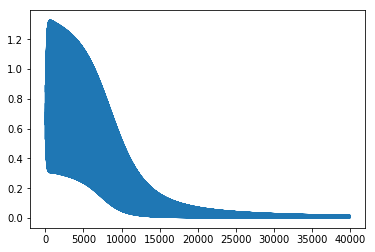

In [24]:
# error関数の誤差をプロット
import matplotlib.pyplot as plt
import math

name = 'logistic&softmax_10000'
x = np.linspace(0, 40000, 40000)  #0から2πまでの範囲を100分割したnumpy配列
# y = np.sin(x)
y = error_list
 
plt.plot(x, y)
plt.show()

In [31]:
# モデルを保存(to_json)
import json
json_data = and_gate.to_json()  # neuronのデータをdictionaryで受け取る

# Pythonオブジェクトをファイル書き込み
savepath = "./neuron_data.json"
with open(savepath, 'w') as outfile:
    json.dump(json_data, outfile)

In [34]:
# ローカルJSONファイルの読み込み
with open('./neuron_data.json', 'r') as f:
    data = json.load(f)
# モデルのパラメータを取り出す
# data
and_gate_1 = Network.from_json(data)
and_gate_1.name

'and_gate'

In [35]:
# テスト
test_input_datum = [[[0,],[0,]],
                    [[0,],[1,]],
                    [[1,],[0,]],
                    [[1,],[1,]]]

In [36]:
for i_data, t_data in zip(test_input_datum, teaching_datum):
    output_data = and_gate.propagate_forward(np.array(i_data))  # forwardの出力結果が誤差関数の入力値にしないと変化がおきないのでoutput_data取得
    print("output=%s" % output_data)
    error_data = and_gate.error_func.get_value(np.array(t_data), output_data)
    print("error=%s" % error_data)
    error_list.append(error_data)
    and_gate.propagate_backward(np.array(i_data), np.array(t_data))
    and_gate.update(np.array(i_data))

output=[[  9.99346419e-01]
 [  6.53580555e-04]]
error=0.000653794231996
output=[[ 0.98811635]
 [ 0.01188365]]
error=0.0119548295789
output=[[ 0.98802871]
 [ 0.01197129]]
error=0.0120435243742
output=[[ 0.01729403]
 [ 0.98270597]]
error=0.0174453165161


In [19]:
# # １層softmax ＋ 交差エントロピー関数の場合
# and_gate_1 = Network('and_gate_1', 2, 'cross_entropy', 0.01)     # error関数に交差エントロピー関数
# and_gate_1.add_layer('softmax', 2)    # アクティベート関数にsoftmax関数
# error_list = []
# for _ in range(10000):
#     for i_data, t_data in zip(input_datum, teaching_datum):
#         output_data = and_gate.propagate_forward(np.array(i_data))  # forwardの出力結果が誤差関数の入力値にしないと変化がおきないのでoutput_data取得
#         print("output=%s" % output_data)
#         error_data = and_gate.error_func.get_value(np.array(t_data), output_data)
#         print("error=%s" % error_data)
#         error_list.append(error_data)
#         and_gate.propagate_backward(np.array(i_data), np.array(t_data))
#         and_gate.update(np.array(i_data))
# # error関数の誤差をプロット
# import matplotlib.pyplot as plt
# import math
 
# x = np.linspace(0, 40000, 40000)  #0から2πまでの範囲を100分割したnumpy配列
# # y = np.sin(x)
# y = error_list
 
# plt.plot(x, y)
# plt.show()

In [20]:
# # 10000回学習    １層softmax  + error関数：交差エントロピー
# # 最初
# output=[[  9.99976265e-01]  # 0の確率   0.999976265          正解は0
#              [  2.37346646e-05]] # 1の確率   0.0000237346646
# error=2.37349462559e-05    # 誤差 0.0000237349462559
# output=[[ 0.97503152]
#              [ 0.02496848]]
# error=0.0252854822782
# output=[[ 0.97502832]
#              [ 0.02497168]]
# error=0.0252887613561
# output=[[ 0.03497661]
#              [ 0.96502339]]
# error=0.0356029398153
# ------
# # 最後
# output=[[  9.99997066e-01]  # 0の確率   0.999997066          正解は0
#              [  2.93364602e-06]] # 1の確率   0.00000293364602
# error=2.93365032537e-06    # 誤差  0.00000293365032537
# output=[[ 0.98738445]
#              [ 0.01261555]]
# error=0.0126958026304
# output=[[ 0.98738366]
#              [ 0.01261634]]
# error=0.0126965992126
# output=[[ 0.01766565]
#              [ 0.98233435]]
# error=0.0178235546967

# コードの追い方
- 気になるポイントを決めてそのmethodをしっかり読み込む
- ある程度、名前をみて想像しながら何をしているのかを読み解く
- さらに気になる先へ飛んでみる

- 本などを読んで勉強するときは、Neuronなどでは自分で入力値を決めて手で計算してながらコードを追いかけてみる
- するとアルゴリズムを理解しやすい

### パラメータのバイアスも自動的に作っている
    def _init_W(self, n_output, n_prev_output, **kwargs):
        """
        Way of initializing weight matrix W
        :param n_output: Number of this layer's output
        :param n_prev_output: Number of previous layer's output
        :param kwargs:
        :return: numpy ndarray object having dimension n_output * n_prev_output
        """
        return np.random.uniform(-1, 1, size=(n_output, n_prev_output))

    def _init_b(self, n_output, **kwargs):
        """
        Way of initializing bias
        :param n_output: Number of this layer's output
        :param kwargs:
        :return: numpy ndarray object having dimension n_output * 1
        """
        return np.random.uniform(-1, 1, size=(n_output, 1))

### and_gate = Network('and_gate', 2, 'se', 0.01)
### 最初のネットワーククラスをインスタンス化しているところ

        入力値( 名前、入力数、エラー関数名、ハイパーパラメータ)を入れている
        エラー関数のみ深くなっていて呼び出している
        def __init__(self, name, n_input, error_func_name, epsilon):
        self._name = name
        self._n_input = n_input
        self._layers = []
        self._error_func = self._get_error_func_by_name(error_func_name)
        self._epsilon = epsilon
        
        呼び出されている先では、定数のエラー関数名を順番にとってきてそのクラスを返している
        _ERROR_FUNCS = [
        SquaredError(),
        CrossEntropy(),
        ]
        def _get_error_func_by_name(self, name):
            for func in self._ERROR_FUNCS:
                if func.name == name:
                    return func
            raise ErrorFuncDoesNotExist(self._ERROR_FUNCS)
            
        エラー関数がSquaredError()と()としているのは
        呼び出した先で('エラー関数名')をnameへ代入している為
        class SquaredError(Function):
            """二乗誤差関数"""
            name = "se"
            
        なので初期値self._error_funcへはエラー関数のインスタンスを入れている
        


### ---------------------------
### and_gate.add_layer('logistic', 1)
### レイヤー名を指定して追加する

### 結構複雑で、
    _LAYER_CLASSES = [
        LogisticLayer,
        TanhLayer,
        SoftmaxLayer,
        RectifierLayer,
    ]
    レイヤー名は初期値では空の[]配列になっており

    def __init__(self, name, n_input, error_func_name, epsilon):
        self._name = name
        self._n_input = n_input
        self._layers = []
        self._error_func = self._get_error_func_by_name(error_func_name)
        self._epsilon = epsilon

    addレイヤーされる時に"logistic"名をtype引数で受け取り
    次の流れは以下のdef get_layer_cls()methodを飛び越えて
    n_prev_outputへ
    この中でself._layers[]リストに入っている一個前のレイヤー名を取り出し
    layer = get_layer_cls(type)(n_output, n_prev_output, **kwargs)によって
    まずget_layer_cls('logistic')で先ほど飛び越したメソッドへlogisticのクラス名でクラスを取得
    そのクラス名へ(n_ouput, n_prev_output)初期値を与えてインスタンスを作成している 受けているのが
    layer = である
    class LogisticLayer(BaseLayer):
    name = 'logistic'

    def __init__(self, n_output, n_prev_output):
        super().__init__(n_output, n_prev_output, Logistic())
        
    'logistic'名のクラス名は初期値を入れるようになっている
    そのインスタンスをself._layers.append追加しておいてる
    
    def add_layer(self, type, n_output, **kwargs):
        def get_layer_cls(type):
            for cls in self._LAYER_CLASSES:
                if cls.name == type:
                    return cls
            raise LayerTypeDoesNotExist(self._LAYER_CLASSES)

        n_prev_output = self._layers[-1].n_output if self._layers else self._n_input
        layer = get_layer_cls(type)(n_output, n_prev_output, **kwargs)
        self._layers.append(layer)

### -----------------
### and_gate.propagate_forward([[0,],[0,]])
### フォワードメソッドについて

      メソッドを呼び出し、一旦入力値をoutput変数へ入れておき
      add_layerで設定されているレイヤーインスタンスが入ったリストを順番に呼び出しいる
      呼び出されたlayerインスタンス.propagate_forward(output)を呼び出している          
      def propagate_forward(self, input_datum):
        output = input_datum
        for layer in self._layers:
            output = layer.propagate_forward(output)
        return output  
        
    呼び出された先のlayerインスタンスのpropagate_forward()がなく親クラスを継承しているのでみてみる
    以下親クラスのpropagate_forward(x)には入力値(x)を受け取ったらすぐに計算して返している
    だから最初の and_gate.propagate_forward([[0,],[0,]])  ここでも入力値のみで値が返されるようになっている
    class LogisticLayer(BaseLayer):
        name = 'logistic'

        def __init__(self, n_output, n_prev_output):
            super().__init__(n_output, n_prev_output, Logistic())
            
    def propagate_forward(self, x):
        self._y = self._f.get_value(self._W @ x + self._b)
        return self._y            
            
        

            
        

### ---------------------
### and_gate.error_func.get_value(np.array([[0, ], [0, ]]), [[0,], ])  
### エラー誤差関数の値を取得しているだけ
    print(and_gate.error_func.get_value(np.array([[0, ], [0, ]]), [[0,], ]))
    入力値の二乗誤差だから0,0 なら必ず０にしかならないし、正解が０なら誤差０なはず
    
    Neuron.error_funcの中のpropatyを呼び出し
    @property
    def error_func(self):
        return self._error_func
    propatyで初期値のerror_funcを呼び出し
        
    def __init__(self, name, n_input, error_func_name, epsilon):
    self._name = name
    self._n_input = n_input
    self._layers = []
    self._error_func = self._get_error_func_by_name(error_func_name)
    self._epsilon = epsilon
    初期値では設定しているerror_func名を指定して呼んでいる
    
    呼び出し先メソッドでは定数をループして指定の名前と一致しているもののインスタンスを作っている
    _ERROR_FUNCS = [
        SquaredError(),
        CrossEntropy(),
    ]
    
    def _get_error_func_by_name(self, name):
    for func in self._ERROR_FUNCS:
        if func.name == name:
            return func
    raise ErrorFuncDoesNotExist(self._ERROR_FUNCS)
    
    そのインスタンスのget_value()メソッドを呼び出しているので値が取得されている流れ
    最初のコード and_gate.error_func.get_value(np.array([[0, ], [0, ]]), [[0,], ])
    error_funcのインスタンスのget_valueでは
    正解値(t)と入力値(y)を与えて　二乗誤差を返しているだけ
    def get_value(self, t, y):
    """通常出力"""
    return ((t - y).T @ (t - y)).ravel()[0] / 2.0  # flatten()よりravel()がいい

### ----------------------
### and_gate.propagate_backward(np.array([[0, ], [0, ]]), [[1,], ])
### 誤差逆伝播については

        def propagate_backward(self, input_datum, teaching_datum):
            delta = self._error_func.get_derivative(teaching_datum, self.propagate_forward(input_datum))

            next_layer = None
            for layer in reversed(self._layers):
                delta = layer.propagate_backward(delta, next_layer.W if next_layer is not None else None)
                next_layer = layer
        まずNetworkの呼び出し先をみると引数を２つ用意してあり入力値・正解データを受け取っている
        次に、微分値をdeltaで受けているがそこが深くなっているのでしらべてみる
        self._error_func.get_derivative()  ではエラー関数の初期値を呼び出しているが最初に設定しており
        'logistic'であればSquaredError()のインスタンスが入っているそのインスタンスの
        get_derivative()methodを呼び出しているが引数に.get_derivative(teaching_datum, self.propagate_forward(input_datum))
        正解データ前後逆だけど、最初に受けとっている正解データを入れて、次に入力値をフォワード関数を呼び出して再度フォワードの出力値を
        求めており、求まった出力値を引数に与えている
        ようやく get_derivative()メソッドだが、
        class SquaredError(Function):
           """二乗誤差関数"""
            name = "se"
    
            def get_value(self, t, y):
            """通常出力"""
                return ((t - y).T @ (t - y)).ravel()[0] / 2.0  # flatten()よりravel()がいい
   
            def get_derivative(self, t, y):
                return -(t - y)
                
            ちゃんとSquaredErrorの微分関数を作って返している
            delta = 受け取った微分関数は最初の代入に戻り
            
            次に
            next_layer = None
            for layer in reversed(self._layers):
            で初期値に持っているlayerを呼び出しながら if next_layer is not Noneでないなら
            delta = layer.propagate_backward(delta, next_layer.W)
            誤差関数で求めた誤差微分関数を引数に渡して、パラメータとともにそのlayerインスタンスの
            propagate_backwardで誤差逆伝播している
            今回であれば、'logistic'シグモイド関数レイヤーだけど、
            クラスをみると、親クラスに一任しているので親クラスのpropagate_backward()をみてみる
            class LogisticLayer(BaseLayer):
                name = 'logistic'

                def __init__(self, n_output, n_prev_output):
                    super().__init__(n_output, n_prev_output, Logistic())
             確認すると親クラスでメソッド用意してあり
             ２層目か１層目かの確認をしており
             今回２層目ならnext_WはNoneなのでelse側へ行き
             (delta, next_layer.W)引数で渡している誤差関数微分とそのレイヤーのパラメータを
             next_deltaとしてdeltaを渡して、next_layer.Wがないので
             self._delta = self._f.get_derivative(self._y) @ next_delta
             こちらを処理している
             こちらでも,next_deltaの誤差関数微分は使われているがさらに内積している
             self._f.get_derivative(self._y) @  
             自身が持つ self._f 関数のget_derivativeを読んでいるがこの自身が持つ self._f は
             ’logistic'であれば、
             class LogisticLayer(BaseLayer):
                name = 'logistic'

            def __init__(self, n_output, n_prev_output):
                super().__init__(n_output, n_prev_output, Logistic())  <--- Logistic()とインスタンスを渡しているのでLogistic()クラスのget_derivative()を呼ぶ
                self._yは入力値
                
            def propagate_backward(self, next_delta, next_W):
                if next_W is not None:
                    self._delta = self._f.get_derivative(self._y) @ next_W.T @ next_delta
                else:
                    self._delta = self._f.get_derivative(self._y) @ next_delta
                return self._delta      
                    
              Logistic()がもつget_derivative()は以下
                 def get_derivative(self, y):
                    assert isinstance(y, np.ndarray) and y.shape[1] == 1
                    jacobian = np.zeros(shape=(y.shape[0], y.shape[0]))
                    jacobian[np.diag_indices(y.shape[0])] = (y * (1 - y)).ravel()
                    return jacobian
            ヤコビ行列を求めているので
            シグモイド関数の行列を出来上がる
        


### -------------
### and_gate.update(np.array([[0, ], [0, ]]))
### 最後にパラメータ調整
        
        def update(self, input_datum):
        prev_layer = None
        for layer in self._layers:
            layer.update(input_datum if prev_layer is None else prev_layer.y, self._epsilon)
            prev_layer = layer
        パラメータ調整だけど、入力値をいれると
        自身がもつレイヤーを呼び出し
        今回では'logistic'だけど、
        Logistic()クラスの.updateを呼んでいる、呼び出し時、引数に
        もし、次のレイヤーがなければ入力値を与えるがあれば、
        そのレイヤーのもつ出力値とハイパーパラメータをupdateへ与える
        layer.update(input_datum if prev_layer is None else prev_layer.y, self._epsilon)
        
        今回'logistic'のみの場合、前の入力値というのは１層でない為
        入力値x1,x2が[0,0]として前の入力値 prev_y引数に当たる
        以上のことから以下updateメソッドでは以前の入力値とハイパーパラメーたを使う時と
        初期入力値とハイパーパラメータを使う場合とある　引数の数が合わなくてもエラーにはならない。
        def update(self, prev_y, epsilon):       # 引数でもし前の入力値がない場合、初期入力値 x1,x2が入る
            Delta_W = self._delta @ prev_y.T  # これはバックプロップの微分のみ
            self._W -= epsilon * Delta_W          # パラメータ調整　W
            self._b -= epsilon * self._delta        # パラメータ調整   b


# 以下あたら行く与えるデータ

えむにストのデータをとってきて
一つの配列にして
それを投げ込む
入力データと正解データがあるので与える
- 正解率を表示
- ビジュアライズ(学習曲線)

# 以下　MPSの更新作業
MPS DEEP
About

A Deep learning library for educational use. Only numpy is used to implement.
Supported layers

    Logistic sigmoid layer
    Tanh layer
    Softmax layer
    Rectifier layer (ReLU)

Supported error functions

    Squared error
    Cross entropy

Other features

    Export/Import network structure to/from JSON.
- この中に英語を追記していく
- 使い方を表記する
- まず、Mnistデータをsklearnからimportして　　コードで書く
- np.arrayの配列を用意して
- 学習回して
- 何回回して正解率◯◯を表示